# Methodology

### Load the dataset

In [1]:
# packages to load

import torch
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import re

from sklearn.model_selection import RepeatedKFold, cross_val_score
from torch.utils.data import DataLoader,TensorDataset,random_split,SubsetRandomSampler
from scipy import stats
from functools import reduce

# matplotlib
%matplotlib inline
matplotlib.style.use("ggplot")

# General pandas
pd.set_option('display.max_colwidth', None)  # Show the entire column 
pd.options.display.max_columns = 100 
pd.options.display.max_rows = 10000 

# Seaborn
sns.set_style("whitegrid")

In [2]:
# load the data set
import os
dataset_path = os.path.join(os.path.curdir, 'WA_Fn-UseC_-HR-Employee-Attrition.csv')
employee_turnover_data =pd.read_csv(dataset_path)

In [3]:
# obtain the dimensions of the dataframe object
# inspect how many records and features there are in the dataset, 1470 records and 35 attributes
employee_turnover_data.shape

(1470, 35)

In [4]:
# Inspect the dataset
# Obtain first few rows of the dataset
employee_turnover_data.head()

,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,EnvironmentSatisfaction,Gender,HourlyRate,JobInvolvement,JobLevel,JobRole,JobSatisfaction,MaritalStatus,MonthlyIncome,MonthlyRate,NumCompaniesWorked,Over18,OverTime,PercentSalaryHike,PerformanceRating,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,41,Yes,Travel_Rarely,1102,Sales,1,2,Life Sciences,1,1,2,Female,94,3,2,Sales Executive,4,Single,5993,19479,8,Y,Yes,11,3,1,80,0,8,0,1,6,4,0,5
1,49,No,Travel_Frequently,279,Research & Development,8,1,Life Sciences,1,2,3,Male,61,2,2,Research Scientist,2,Married,5130,24907,1,Y,No,23,4,4,80,1,10,3,3,10,7,1,7
2,37,Yes,Travel_Rarely,1373,Research & Development,2,2,Other,1,4,4,Male,92,2,1,Laboratory Technician,3,Single,2090,2396,6,Y,Yes,15,3,2,80,0,7,3,3,0,0,0,0
3,33,No,Travel_Frequently,1392,Research & Development,3,4,Life Sciences,1,5,4,Female,56,3,1,Research Scientist,3,Married,2909,23159,1,Y,Yes,11,3,3,80,0,8,3,3,8,7,3,0
4,27,No,Travel_Rarely,591,Research & Development,2,1,Medical,1,7,1,Male,40,3,1,Laboratory Technician,2,Married,3468,16632,9,Y,No,12,3,4,80,1,6,3,3,2,2,2,2


In [5]:
# convert Attrition to numerical data type

nominal_boolean_mapping = {
    'Attrition': {'Yes': 1.0, 'No': 0.0},
}
for column, mapping in nominal_boolean_mapping.items():
    employee_turnover_data[column] = employee_turnover_data[column].map(mapping)

### Exploratory data analysis. Check if findings from theory hold for this dataset.
#### Turnover theories claim that employees exit an organization because they are not satisfied with their current job.

#### 1. Overall Job Satisfaction
##### As it can be seen from the graph, half of the employees that have exit the company, report a job satisfaction that is smaller than 2.5. Whereas, the other half, have actually a job satisfaction that is similar to or greater than 3. Hence, job satisfaction cannot be the only reason why emplyoees leave the current job.

In [32]:
# from 1470 records in total, only 237 records indicate employees that have exited the organization
employee_turnover_data['Attrition'].value_counts()

0.0    1233
1.0     237
Name: Attrition, dtype: int64

<AxesSubplot:xlabel='JobSatisfaction', ylabel='Count'>

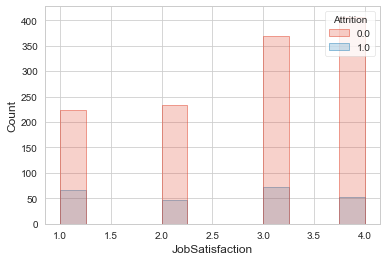

In [33]:
sns.histplot(employee_turnover_data, x="JobSatisfaction", hue="Attrition", element="step")

#### 2. Job embeddedness, which analyzes the fit of an employee in the job environment as well as in the community, his or her relationship ties in both these environments, and what the employee would sacrifice if he or she left the job, is positively and significantly correlated to job satisfaction. These components could be translated to the following variables that are present in the dataset.

##### (a) Fit in the job environment and community; EnvironmentSatisfaction, JobInvolvement                                                                                            (b) Relationship ties in both environments; RelationshipSatisfaction, YearsWithCurrManager                                                                                          (c)  Sacrifice if employee left current position; YearsAtCompany, YearsInCurrentRole

In [34]:
# a.1 EnvironmentSatisfaction vs. JobSatisfaction
employee_turnover_data['EnvironmentSatisfaction'].value_counts()

3    453
4    446
2    287
1    284
Name: EnvironmentSatisfaction, dtype: int64

In [35]:
# According to the results below, there is a significant large number of employees that 
# are not satisifed with the environment, yet have not exit the organization

df = employee_turnover_data.groupby(['EnvironmentSatisfaction','Attrition'])['Attrition'].count()
print(df)

EnvironmentSatisfaction  Attrition
1                        0.0          212
                         1.0           72
2                        0.0          244
                         1.0           43
3                        0.0          391
                         1.0           62
4                        0.0          386
                         1.0           60
Name: Attrition, dtype: int64


In [36]:
# There are many employees that are not satisfied with the working environment, but show high levels of Job Satisfaction
# Hence, in this particular dataset, no relation can be concluded between EnvironmentSatisfaction and JobSatisfaction

df = employee_turnover_data.groupby(['EnvironmentSatisfaction','JobSatisfaction'])['JobSatisfaction'].count()
print(df)

EnvironmentSatisfaction  JobSatisfaction
1                        1                   53
                         2                   47
                         3                  100
                         4                   84
2                        1                   55
                         2                   59
                         3                   84
                         4                   89
3                        1                   94
                         2                   87
                         3                  128
                         4                  144
4                        1                   87
                         2                   87
                         3                  130
                         4                  142
Name: JobSatisfaction, dtype: int64


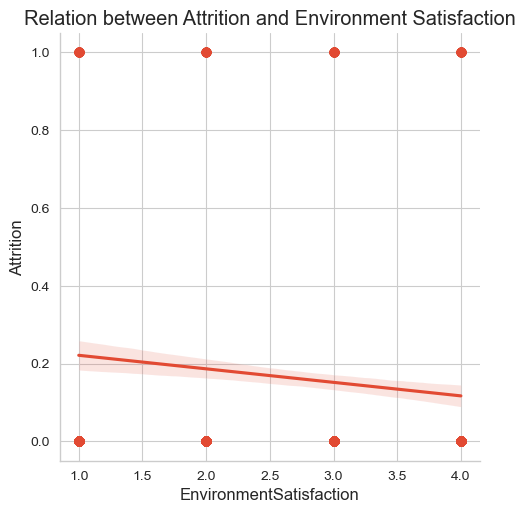

In [37]:
# the regression line between EnvironmentSatisfaction and JobSatisfaction has a slope almost 0, which does not tell anything
# However, there is a negative correlation between Environment Satisfaction and Attrition

plt.rcParams.update({'figure.figsize':(10,8), 'figure.dpi':100})
sns.lmplot(x='EnvironmentSatisfaction', y='Attrition', data=employee_turnover_data)
plt.title("Relation between Attrition and Environment Satisfaction");

In [38]:
# a.2 JobInvolvement vs. JobSatisfaction
employee_turnover_data['JobInvolvement'].value_counts()

3    868
2    375
4    144
1     83
Name: JobInvolvement, dtype: int64

In [39]:
# According to the results below, employees that are highly involved in their job are still with the company

df = employee_turnover_data.groupby(['JobInvolvement','Attrition'])['Attrition'].count()
print(df)

JobInvolvement  Attrition
1               0.0           55
                1.0           28
2               0.0          304
                1.0           71
3               0.0          743
                1.0          125
4               0.0          131
                1.0           13
Name: Attrition, dtype: int64


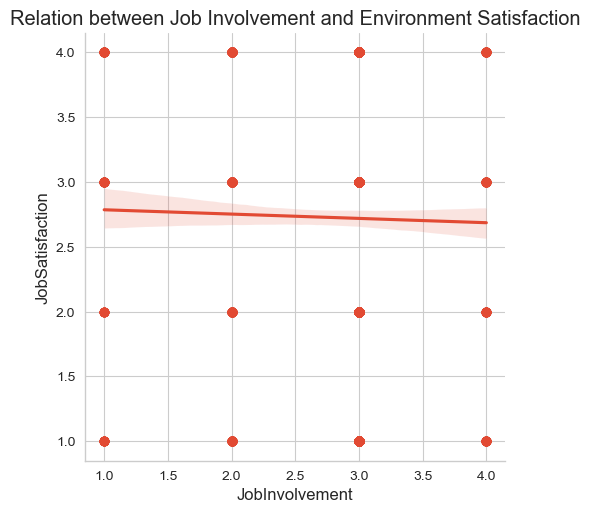

In [40]:
# Regression line between JobInvolvement and JobSatisfaction has a slope almost 0
# Hence, no certain relations can be concluded between these two variables

plt.rcParams.update({'figure.figsize':(10,8), 'figure.dpi':100})
sns.lmplot(x='JobInvolvement', y='JobSatisfaction', data=employee_turnover_data)
plt.title("Relation between Job Involvement and Environment Satisfaction");

In [41]:
# The majority of the employees have reported an average score of job involvement, regardless of their job satisfaction
# Hence, in this particular dataset, no relation can be concluded between EnvironmentSatisfaction and JobSatisfaction

df = employee_turnover_data.groupby(['JobInvolvement','JobSatisfaction'])['JobSatisfaction'].count()
print(df)

JobInvolvement  JobSatisfaction
1               1                   14
                2                   10
                3                   28
                4                   31
2               1                   75
                2                   81
                3                  108
                4                  111
3               1                  166
                2                  164
                3                  263
                4                  275
4               1                   34
                2                   25
                3                   43
                4                   42
Name: JobSatisfaction, dtype: int64


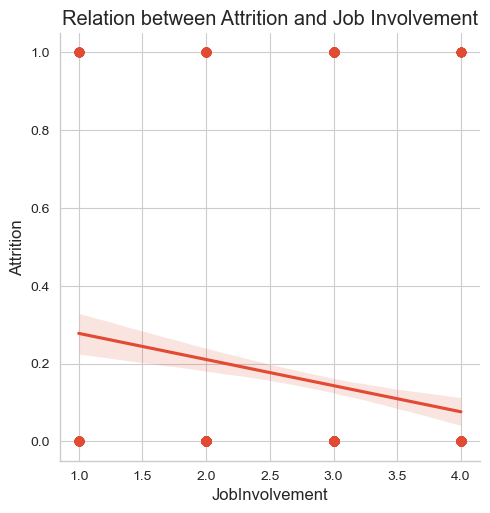

In [42]:
# However, there seams to be a negative correlation between JobInvolvement and Attrition

plt.rcParams.update({'figure.figsize':(10,8), 'figure.dpi':100})
sns.lmplot(x='JobInvolvement', y='Attrition', data=employee_turnover_data)
plt.title("Relation between Attrition and Job Involvement");

In [43]:
# b.1 RelationshipSatisfaction vs. JobSatisfaction
employee_turnover_data['RelationshipSatisfaction'].value_counts()

3    459
4    432
2    303
1    276
Name: RelationshipSatisfaction, dtype: int64

In [44]:
# According to the results below, employees that are satisfied with the relations they have created in the current job 
# are still with the company

df = employee_turnover_data.groupby(['RelationshipSatisfaction','Attrition'])['Attrition'].count()
print(df)

RelationshipSatisfaction  Attrition
1                         0.0          219
                          1.0           57
2                         0.0          258
                          1.0           45
3                         0.0          388
                          1.0           71
4                         0.0          368
                          1.0           64
Name: Attrition, dtype: int64


In [45]:
# The majority of the employees have reported an average score of job involvement, regardless of their job satisfaction
# Hence, in this particular dataset, no relation can be concluded between RelationshipSatisfaction and JobSatisfaction

df = employee_turnover_data.groupby(['RelationshipSatisfaction','JobSatisfaction'])['JobSatisfaction'].count()
print(df)

RelationshipSatisfaction  JobSatisfaction
1                         1                   54
                          2                   53
                          3                   85
                          4                   84
2                         1                   57
                          2                   57
                          3                   94
                          4                   95
3                         1                   91
                          2                   81
                          3                  133
                          4                  154
4                         1                   87
                          2                   89
                          3                  130
                          4                  126
Name: JobSatisfaction, dtype: int64


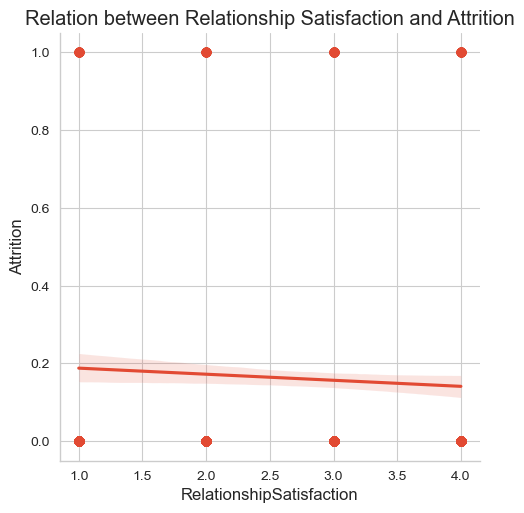

In [46]:
# However, there seams to be a negative correlation between RelationshipSatisfaction and Attrition

plt.rcParams.update({'figure.figsize':(10,8), 'figure.dpi':100})
sns.lmplot(x='RelationshipSatisfaction', y='Attrition', data=employee_turnover_data)
plt.title("Relation between Relationship Satisfaction and Attrition");

In [47]:
# b.2 YearsWithCurrManager vs. JobSatisfaction
employee_turnover_data['YearsWithCurrManager'].value_counts()

2     344
0     263
7     216
3     142
8     107
4      98
1      76
9      64
5      31
6      29
10     27
11     22
12     18
13     14
17      7
15      5
14      5
16      2
Name: YearsWithCurrManager, dtype: int64

In [48]:
# According to the results below, almost half of the employees report a high level of job satisfaction, 
# regardless of how many years they have been working with the current manager
 
df = employee_turnover_data[employee_turnover_data['JobSatisfaction'] == 4].groupby(['YearsWithCurrManager', 'JobSatisfaction']).size()
print(df)


YearsWithCurrManager  JobSatisfaction
0                     4                   78
1                     4                   31
2                     4                  103
3                     4                   42
4                     4                   36
5                     4                   11
6                     4                    7
7                     4                   66
8                     4                   38
9                     4                   21
10                    4                    6
11                    4                    9
12                    4                    5
13                    4                    2
15                    4                    1
17                    4                    3
dtype: int64


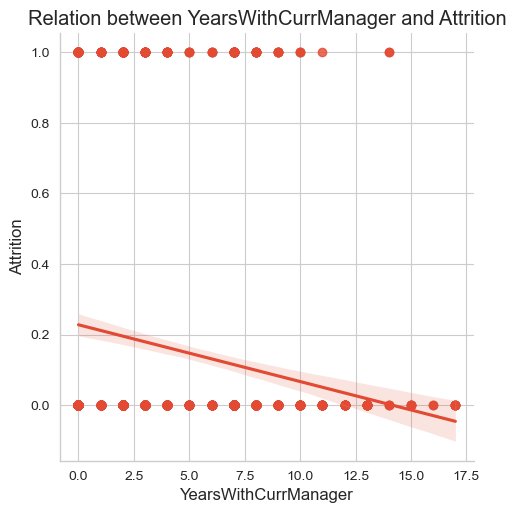

In [49]:
# No relation can be concluded between job satisfaction and working years with the current manager
# However, there seams to be a negative correlation between YearsWithCurrManager and Attrition, even though a few outliers exist

plt.rcParams.update({'figure.figsize':(10,8), 'figure.dpi':100})
sns.lmplot(x='YearsWithCurrManager', y='Attrition', data=employee_turnover_data)
plt.title("Relation between YearsWithCurrManager and Attrition");

In [50]:
# c.1 YearsAtCompany vs. JobSatisfaction
employee_turnover_data['YearsAtCompany'].value_counts()

5     196
1     171
3     128
2     127
10    120
4     110
7      90
9      82
8      80
6      76
0      44
11     32
20     27
13     24
15     20
14     18
22     15
12     14
21     14
18     13
16     12
19     11
17      9
24      6
33      5
25      4
26      4
31      3
32      3
27      2
36      2
29      2
23      2
37      1
40      1
34      1
30      1
Name: YearsAtCompany, dtype: int64

In [51]:
# According to the reported values below, no pattern could be revealed between job satisfaction and years at company
# Hence no relation can be concluded between YearsAtCompany and JobSatisfaction

df = employee_turnover_data.groupby(['YearsAtCompany','JobSatisfaction'])['JobSatisfaction'].count()
print(df)

YearsAtCompany  JobSatisfaction
0               1                  12
                2                   5
                3                  16
                4                  11
1               1                  31
                2                  39
                3                  48
                4                  53
2               1                  19
                2                  21
                3                  44
                4                  43
3               1                  31
                2                  24
                3                  39
                4                  34
4               1                  27
                2                  21
                3                  31
                4                  31
5               1                  36
                2                  38
                3                  63
                4                  59
6               1                  13
                2 

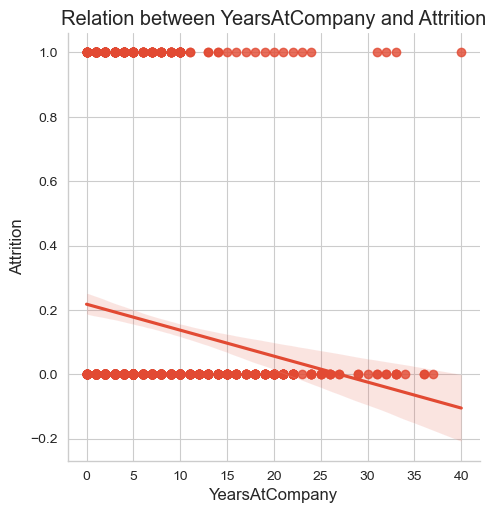

In [52]:
# No relation can be concluded between job satisfaction and total years working for the company
# However, there seems to be a negative correlation between YearsAtCompany and Attrition, even though a few outliers exist

plt.rcParams.update({'figure.figsize':(10,8), 'figure.dpi':100})
sns.lmplot(x='YearsAtCompany', y='Attrition', data=employee_turnover_data)
plt.title("Relation between YearsAtCompany and Attrition");

In [53]:
# c.2 YearsInCurrentRole vs. JobSatisfaction
employee_turnover_data['YearsInCurrentRole'].value_counts()

2     372
0     244
7     222
3     135
4     104
8      89
9      67
1      57
6      37
5      36
10     29
11     22
13     14
14     11
12     10
15      8
16      7
17      4
18      2
Name: YearsInCurrentRole, dtype: int64

In [54]:
# According to the values below, a significant number of the employees have reported a high score of job satisfaction, 
# regardless of the number of years that they have spend in the current role at the company.
# In particular, employees that have been working in the current role for 2 years, show the highest job satisfaction

df = employee_turnover_data[employee_turnover_data['JobSatisfaction'] == 4].groupby(['YearsInCurrentRole', 'JobSatisfaction']).size()
print(df)

YearsInCurrentRole  JobSatisfaction
0                   4                   76
1                   4                   20
2                   4                  114
3                   4                   37
4                   4                   28
5                   4                   16
6                   4                    9
7                   4                   78
8                   4                   32
9                   4                   19
10                  4                   10
11                  4                    9
12                  4                    3
13                  4                    2
14                  4                    4
17                  4                    2
dtype: int64


In [55]:
# Whereas the number of employees having a job satisfaction equal to 1, 2 and 3 seems evenly distributed regardless of the years in current role

df = employee_turnover_data[employee_turnover_data['JobSatisfaction'] == 3].groupby(['YearsInCurrentRole', 'JobSatisfaction']).size()
print(df)

YearsInCurrentRole  JobSatisfaction
0                   3                   72
1                   3                   16
2                   3                  117
3                   3                   43
4                   3                   35
5                   3                    7
6                   3                    9
7                   3                   66
8                   3                   21
9                   3                   18
10                  3                    8
11                  3                    7
12                  3                    2
13                  3                    4
14                  3                    6
15                  3                    4
16                  3                    4
17                  3                    1
18                  3                    2
dtype: int64


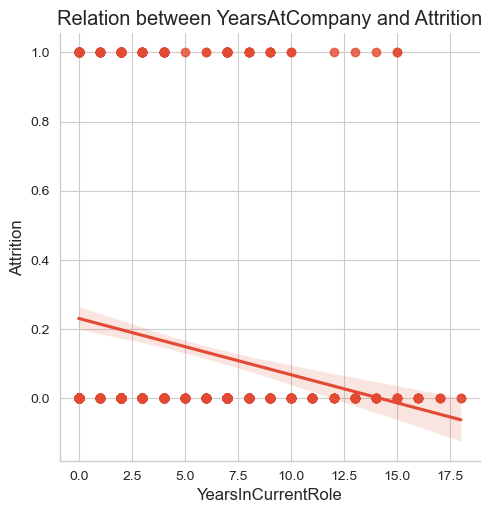

In [56]:
# Hence, even though no particular relation can be concluded between job satisfaction and total years in current role
# There seems to be a negative correlation between YearsInCurrentRole and Attrition

plt.rcParams.update({'figure.figsize':(10,8), 'figure.dpi':100})
sns.lmplot(x='YearsInCurrentRole', y='Attrition', data=employee_turnover_data)
plt.title("Relation between YearsAtCompany and Attrition");

#### 3. Workload
##### Moreover, job satisfaction is also effected by a high workload, work exhaustion, and the work-life balance.

In [57]:
# OverTime vs. JobSatisfaction
employee_turnover_data['OverTime'].value_counts()

No     1054
Yes     416
Name: OverTime, dtype: int64

In [58]:
# According to the results below, there is a higher number of employees that have worked overtime and have not yet exited, 
# compared to the number of employees that haven't worked overtime but have still terminated the employment contract

df = employee_turnover_data.groupby(['OverTime','Attrition'])['Attrition'].count()
print(df)

OverTime  Attrition
No        0.0          944
          1.0          110
Yes       0.0          289
          1.0          127
Name: Attrition, dtype: int64


In [59]:
# According to the results below, there is a higher number of employees that have worked overtime and are still satisfieed with their jobs, 
# compared to the number of employees that haven't worked overtime and have reported low job satisfaction scores

df = employee_turnover_data.groupby(['OverTime','JobSatisfaction'])['JobSatisfaction'].count()
print(df)

OverTime  JobSatisfaction
No        1                  205
          2                  211
          3                  321
          4                  317
Yes       1                   84
          2                   69
          3                  121
          4                  142
Name: JobSatisfaction, dtype: int64


In [60]:
# Work-life Balance vs. JobSatisfaction
employee_turnover_data['WorkLifeBalance'].value_counts()

3    893
2    344
4    153
1     80
Name: WorkLifeBalance, dtype: int64

In [61]:
# The values below do no help to conclude any relation between WLB and job satisfaction

df = employee_turnover_data.groupby(['WorkLifeBalance','JobSatisfaction'])['JobSatisfaction'].count()
print(df)

WorkLifeBalance  JobSatisfaction
1                1                   17
                 2                   18
                 3                   21
                 4                   24
2                1                   61
                 2                   58
                 3                  101
                 4                  124
3                1                  182
                 2                  175
                 3                  273
                 4                  263
4                1                   29
                 2                   29
                 3                   47
                 4                   48
Name: JobSatisfaction, dtype: int64


In [62]:
# WLB vs Attrition

# According to the results below, many employees that have reported an average or below average WLB score have exited the company
# However, there is still a significant number of employees (341) that have reported a below average WLB score and are still with the company
# It is surprising that only a small number of emplyoees have reported a very high score of WLB, and there are also
# emplyoees that have reported a high score of WLB and have still excited the company

df = employee_turnover_data.groupby(['WorkLifeBalance','Attrition'])['Attrition'].count()
print(df)

WorkLifeBalance  Attrition
1                0.0           55
                 1.0           25
2                0.0          286
                 1.0           58
3                0.0          766
                 1.0          127
4                0.0          126
                 1.0           27
Name: Attrition, dtype: int64


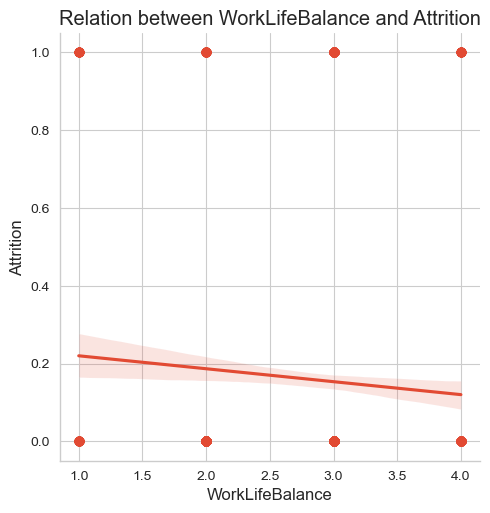

In [63]:
# There seams to be a negative correlation between WorkLifeBalance and Attrition
# There are however, a few outliers

plt.rcParams.update({'figure.figsize':(10,8), 'figure.dpi':100})
sns.lmplot(x='WorkLifeBalance', y='Attrition', data=employee_turnover_data)
plt.title("Relation between WorkLifeBalance and Attrition");

### Data Preprocessing steps

Steps:

1. Data Cleaning

    Check for missing values
    Drop duplicate records

2. Data Transformation

    Convert categorical and string data types to numerical type
    Set the target feature

3. Data Reduction

    Remove columns with a lack of cardinality


#### Data Cleaning

In [6]:
#### Check for missing values and duplicates

# check for missiong values
are_values_missing = employee_turnover_data.isnull().values.any()
print(f'Are values missing? {are_values_missing}')

# drop duplicate records and do not create another copy of the dataframe
employee_turnover_data.drop_duplicates(inplace=True)

Are values missing? False


In [7]:
# Create a dataframe for holding the normalized data
transformed_turnover_data = employee_turnover_data.copy()

# create separate continuous and categorical dataframes

# Create a dataframe with numerical columns 
numeric_df = employee_turnover_data.select_dtypes(include = ['int64', 'float64'])
print(f'Numerical columns:\n{list(numeric_df.columns.values)}\n')

# Create a dataframe with categorical columns 
categoric_df = employee_turnover_data.select_dtypes(include =['object'])
print(f'Numerical columns:\n{list(categoric_df.columns.values)}\n')

Numerical columns:
['Age', 'Attrition', 'DailyRate', 'DistanceFromHome', 'Education', 'EmployeeCount', 'EmployeeNumber', 'EnvironmentSatisfaction', 'HourlyRate', 'JobInvolvement', 'JobLevel', 'JobSatisfaction', 'MonthlyIncome', 'MonthlyRate', 'NumCompaniesWorked', 'PercentSalaryHike', 'PerformanceRating', 'RelationshipSatisfaction', 'StandardHours', 'StockOptionLevel', 'TotalWorkingYears', 'TrainingTimesLastYear', 'WorkLifeBalance', 'YearsAtCompany', 'YearsInCurrentRole', 'YearsSinceLastPromotion', 'YearsWithCurrManager']

Numerical columns:
['BusinessTravel', 'Department', 'EducationField', 'Gender', 'JobRole', 'MaritalStatus', 'Over18', 'OverTime']



#### Transform ordinal categories

BusinessTravel is ordinal data where there is a relationship:  
Non-Travel < Travel_Rarely < Travel_Frequently  

Therefore BusinessTravel will maps its values  
Non-Travel, Travel_Rarely, Travel_Frequently to numeric values 0, 1, 2

In [8]:
transformed_turnover_data['BusinessTravel'] = employee_turnover_data['BusinessTravel'].map(
    {'Non-Travel':0.0 ,'Travel_Rarely':1.0,'Travel_Frequently':2.0})
transformed_turnover_data['BusinessTravel'].head(10)

0    1.0
1    2.0
2    1.0
3    2.0
4    1.0
5    2.0
6    1.0
7    1.0
8    2.0
9    1.0
Name: BusinessTravel, dtype: float64

#### Transform multi-value nominal categories
Categorical features that are nominal if the data values have no relationship with each other.
Such nominal features with more than 2 distinct values with be pre-processed using Effect Encoding (or Sum Encoding), which creates a column per distinct value, except for one. The new columns are encoded with __1__ if the value is present and __0__ if the value is absent. If all the distict value columns are encoded with __-1__, this indicates the presence of the one distinc value which does not have a column.

| Deparment | Department_Sales | Department_Research_Development |
| --- | --- | --- |
| Sales | 1 | 0 |
| Research & Development | 0 | 1 |
| Human Resources | -1 | -1 |

In [9]:
# All multi-value nominal categories
nominal_categories = ['Department','EducationField','JobRole', 'MaritalStatus']
nominal_distinct_values = {}

# What are the distinct values of each nominal category
for nominal_category in nominal_categories:
    nominal_distinct_values[nominal_category] = employee_turnover_data[nominal_category].unique()
    print(f'Distinct values for {nominal_category}: {nominal_distinct_values[nominal_category]}')

Distinct values for Department: ['Sales' 'Research & Development' 'Human Resources']
Distinct values for EducationField: ['Life Sciences' 'Other' 'Medical' 'Marketing' 'Technical Degree'
 'Human Resources']
Distinct values for JobRole: ['Sales Executive' 'Research Scientist' 'Laboratory Technician'
 'Manufacturing Director' 'Healthcare Representative' 'Manager'
 'Sales Representative' 'Research Director' 'Human Resources']
Distinct values for MaritalStatus: ['Single' 'Married' 'Divorced']


In [10]:
# Apply effect encoding for nominal multivalue columns
import warnings
warnings.filterwarnings('ignore')
from category_encoders.sum_coding import SumEncoder

sum_encoder = SumEncoder(cols=nominal_categories,verbose=False,drop_invariant=True,return_df=True,)
nominal_categories_df = sum_encoder.fit_transform(employee_turnover_data[nominal_categories])
new_nominal_columns = list(nominal_categories_df.columns.values)
transformed_turnover_data.drop(columns=new_nominal_columns, errors='ignore', inplace=True)
transformed_turnover_data.drop(columns=nominal_categories, errors='ignore', inplace=True)
transformed_turnover_data = transformed_turnover_data.join(nominal_categories_df)

transformed_turnover_data
column_mapping = {}
for nominal_category, distinct_values in nominal_distinct_values.items():
    for index, value in enumerate(distinct_values):
        if index != len(distinct_values) - 1:
            current_column_name = f'{nominal_category}_{index}'
            clean_name = value.replace('&', '').replace('  ', '_').replace(' ', '_')
            new_column_name = f'{nominal_category}_{clean_name}'
            column_mapping[current_column_name] = new_column_name

transformed_turnover_data.rename(columns=column_mapping, inplace=True)

transformed_turnover_data.head()

,Age,Attrition,BusinessTravel,DailyRate,DistanceFromHome,Education,EmployeeCount,EmployeeNumber,EnvironmentSatisfaction,Gender,HourlyRate,JobInvolvement,JobLevel,JobSatisfaction,MonthlyIncome,MonthlyRate,NumCompaniesWorked,Over18,OverTime,PercentSalaryHike,PerformanceRating,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager,Department_Sales,Department_Research_Development,EducationField_Life_Sciences,EducationField_Other,EducationField_Medical,EducationField_Marketing,EducationField_Technical_Degree,JobRole_Sales_Executive,JobRole_Research_Scientist,JobRole_Laboratory_Technician,JobRole_Manufacturing_Director,JobRole_Healthcare_Representative,JobRole_Manager,JobRole_Sales_Representative,JobRole_Research_Director,MaritalStatus_Single,MaritalStatus_Married
0,41,1.0,1.0,1102,1,2,1,1,2,Female,94,3,2,4,5993,19479,8,Y,Yes,11,3,1,80,0,8,0,1,6,4,0,5,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,49,0.0,2.0,279,8,1,1,2,3,Male,61,2,2,2,5130,24907,1,Y,No,23,4,4,80,1,10,3,3,10,7,1,7,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,37,1.0,1.0,1373,2,2,1,4,4,Male,92,2,1,3,2090,2396,6,Y,Yes,15,3,2,80,0,7,3,3,0,0,0,0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,33,0.0,2.0,1392,3,4,1,5,4,Female,56,3,1,3,2909,23159,1,Y,Yes,11,3,3,80,0,8,3,3,8,7,3,0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,27,0.0,1.0,591,2,1,1,7,1,Male,40,3,1,2,3468,16632,9,Y,No,12,3,4,80,1,6,3,3,2,2,2,2,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


#### Transform boolean nominal data

Text labels such as 'Yes' or 'No' are used for representing boolean data. These labels will be replaced by numeric data such as 1.0 and 0.0.

In [11]:
nominal_boolean_mapping = { 
    
    'Gender': {'Female': 1.0, 'Male': 0.0}, 
    'OverTime': {'Yes': 1.0, 'No': 0.0}
}
for column, mapping in nominal_boolean_mapping.items():
    transformed_turnover_data[column] = employee_turnover_data[column].map(mapping)

transformed_turnover_data.head()

,Age,Attrition,BusinessTravel,DailyRate,DistanceFromHome,Education,EmployeeCount,EmployeeNumber,EnvironmentSatisfaction,Gender,HourlyRate,JobInvolvement,JobLevel,JobSatisfaction,MonthlyIncome,MonthlyRate,NumCompaniesWorked,Over18,OverTime,PercentSalaryHike,PerformanceRating,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager,Department_Sales,Department_Research_Development,EducationField_Life_Sciences,EducationField_Other,EducationField_Medical,EducationField_Marketing,EducationField_Technical_Degree,JobRole_Sales_Executive,JobRole_Research_Scientist,JobRole_Laboratory_Technician,JobRole_Manufacturing_Director,JobRole_Healthcare_Representative,JobRole_Manager,JobRole_Sales_Representative,JobRole_Research_Director,MaritalStatus_Single,MaritalStatus_Married
0,41,1.0,1.0,1102,1,2,1,1,2,1.0,94,3,2,4,5993,19479,8,Y,1.0,11,3,1,80,0,8,0,1,6,4,0,5,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,49,0.0,2.0,279,8,1,1,2,3,0.0,61,2,2,2,5130,24907,1,Y,0.0,23,4,4,80,1,10,3,3,10,7,1,7,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,37,1.0,1.0,1373,2,2,1,4,4,0.0,92,2,1,3,2090,2396,6,Y,1.0,15,3,2,80,0,7,3,3,0,0,0,0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,33,0.0,2.0,1392,3,4,1,5,4,1.0,56,3,1,3,2909,23159,1,Y,1.0,11,3,3,80,0,8,3,3,8,7,3,0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,27,0.0,1.0,591,2,1,1,7,1,0.0,40,3,1,2,3468,16632,9,Y,0.0,12,3,4,80,1,6,3,3,2,2,2,2,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


#### Standardize Numerical Data
Standardizing a dataset involves rescaling the distribution of values so that the mean of observed values is 0 and the standard deviation is 1.

In [12]:
numeric_columns = []
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import MinMaxScaler
trans = MinMaxScaler()

trasformed_numeric_df = pd.DataFrame(trans.fit_transform(numeric_df), 
                                columns=numeric_df.columns,
                                index=numeric_df.index)

transformed_turnover_data.replace(trasformed_numeric_df, inplace=True)

transformed_turnover_data.head()

,Age,Attrition,BusinessTravel,DailyRate,DistanceFromHome,Education,EmployeeCount,EmployeeNumber,EnvironmentSatisfaction,Gender,HourlyRate,JobInvolvement,JobLevel,JobSatisfaction,MonthlyIncome,MonthlyRate,NumCompaniesWorked,Over18,OverTime,PercentSalaryHike,PerformanceRating,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager,Department_Sales,Department_Research_Development,EducationField_Life_Sciences,EducationField_Other,EducationField_Medical,EducationField_Marketing,EducationField_Technical_Degree,JobRole_Sales_Executive,JobRole_Research_Scientist,JobRole_Laboratory_Technician,JobRole_Manufacturing_Director,JobRole_Healthcare_Representative,JobRole_Manager,JobRole_Sales_Representative,JobRole_Research_Director,MaritalStatus_Single,MaritalStatus_Married
0,0.214286,0.0,1.0,0.755190,0.250000,0.25,0,0.000484,1.000000,1.0,0.814286,0.666667,0.00,0.333333,5993.0,19479,0.000000,Y,1.0,0.071429,0,1.000000,0,0.000000,0.250,0.0,0.666667,0.025,0.111111,0.000000,0.352941,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,0.404762,1.0,2.0,0.497495,0.785714,0.00,0,0.001451,1.000000,0.0,0.285714,0.333333,0.00,0.666667,5130.0,24907,0.111111,Y,0.0,0.214286,0,1.000000,0,0.333333,0.150,0.5,0.666667,0.125,0.000000,0.066667,0.000000,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,0.404762,0.0,1.0,0.924839,0.035714,0.25,0,0.002903,0.000000,0.0,0.471429,0.333333,0.25,0.666667,2090.0,2396,0.444444,Y,1.0,0.000000,0,0.333333,0,0.000000,0.025,0.5,0.666667,0.150,0.222222,0.000000,0.294118,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,0.500000,1.0,2.0,0.803150,0.071429,0.00,0,0.003387,0.000000,1.0,0.585714,0.666667,0.25,0.666667,2909.0,23159,0.111111,Y,1.0,0.071429,0,0.666667,0,0.000000,0.250,0.5,0.666667,0.225,0.000000,0.200000,0.294118,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,0.571429,1.0,1.0,0.011453,0.035714,0.00,0,0.004838,0.666667,0.0,0.642857,0.666667,0.25,0.666667,3468.0,16632,0.666667,Y,0.0,0.428571,0,1.000000,0,0.333333,0.300,0.5,0.666667,0.000,0.000000,0.000000,0.000000,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


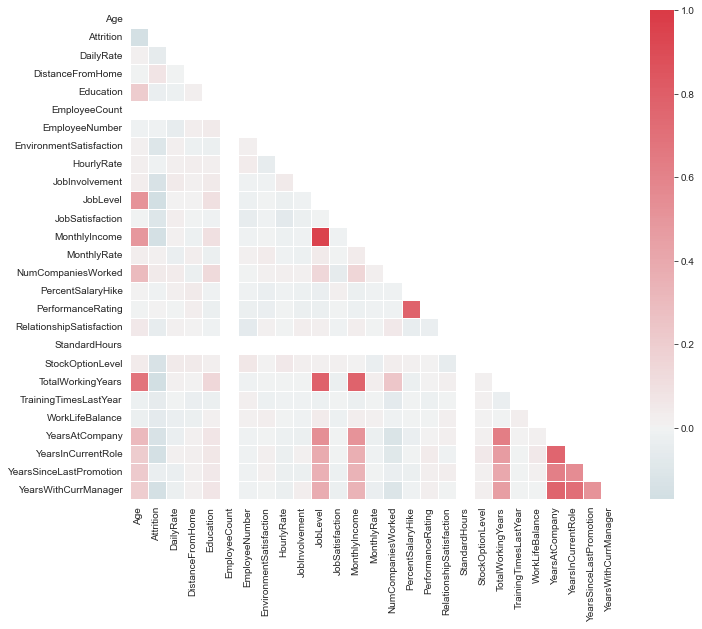

In [15]:
# Subset the dataset into all the numerical values
numeric_hr = employee_turnover_data.select_dtypes(include=[np.number])

# correlation matrix
corr = numeric_hr._get_numeric_data().corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
heatmap = sns.heatmap(corr, mask=mask, cmap=cmap, center=0.0,
                      vmax = 1, square=True, linewidths=.5, ax=ax)
plt.savefig('corr-heat.png')
plt.show()

### Data Reduction

Remove data with low-cardinality (low variance) such as EmployeeCount, StandardHours and Over18.

In [23]:
transformed_turnover_data.shape

(1470, 48)

In [24]:
transformed_turnover_data.drop(columns=['EmployeeCount', 'EmployeeNumber', 'StandardHours', 'Over18'], errors='ignore', inplace=True)
transformed_turnover_data.head()

,Age,Attrition,BusinessTravel,DailyRate,DistanceFromHome,Education,EnvironmentSatisfaction,Gender,HourlyRate,JobInvolvement,JobLevel,JobSatisfaction,MonthlyIncome,MonthlyRate,NumCompaniesWorked,OverTime,PercentSalaryHike,PerformanceRating,RelationshipSatisfaction,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager,Department_Sales,Department_Research_Development,EducationField_Life_Sciences,EducationField_Other,EducationField_Medical,EducationField_Marketing,EducationField_Technical_Degree,JobRole_Sales_Executive,JobRole_Research_Scientist,JobRole_Laboratory_Technician,JobRole_Manufacturing_Director,JobRole_Healthcare_Representative,JobRole_Manager,JobRole_Sales_Representative,JobRole_Research_Director,MaritalStatus_Single,MaritalStatus_Married
0,0.214286,0.0,1.0,0.755190,0.250000,0.25,1.000000,1.0,0.814286,0.666667,0.00,0.333333,5993.0,19479,0.000000,1.0,0.071429,0,1.000000,0.000000,0.250,0.0,0.666667,0.025,0.111111,0.000000,0.352941,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,0.404762,1.0,2.0,0.497495,0.785714,0.00,1.000000,0.0,0.285714,0.333333,0.00,0.666667,5130.0,24907,0.111111,0.0,0.214286,0,1.000000,0.333333,0.150,0.5,0.666667,0.125,0.000000,0.066667,0.000000,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,0.404762,0.0,1.0,0.924839,0.035714,0.25,0.000000,0.0,0.471429,0.333333,0.25,0.666667,2090.0,2396,0.444444,1.0,0.000000,0,0.333333,0.000000,0.025,0.5,0.666667,0.150,0.222222,0.000000,0.294118,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,0.500000,1.0,2.0,0.803150,0.071429,0.00,0.000000,1.0,0.585714,0.666667,0.25,0.666667,2909.0,23159,0.111111,1.0,0.071429,0,0.666667,0.000000,0.250,0.5,0.666667,0.225,0.000000,0.200000,0.294118,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,0.571429,1.0,1.0,0.011453,0.035714,0.00,0.666667,0.0,0.642857,0.666667,0.25,0.666667,3468.0,16632,0.666667,0.0,0.428571,0,1.000000,0.333333,0.300,0.5,0.666667,0.000,0.000000,0.000000,0.000000,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [25]:
# Remove data that are highly correlated 
# - Age is highly correlated to TotalWorkingYears, so Age can be dropped
# - Job Level has a high correlation with MonthlyIncome, hence JobLevel can be dropped
# - Drop HourlyRate, DailyRate, and MonthlyRate because they represent salary, which is represented by MonthlyIncome

transformed_turnover_data.drop(columns=['HourlyRate', 'DailyRate', 'MonthlyRate', 'Age', 'JobLevel'], errors='ignore', inplace=True)
transformed_turnover_data.head()

,Attrition,BusinessTravel,DistanceFromHome,Education,EnvironmentSatisfaction,Gender,JobInvolvement,JobSatisfaction,MonthlyIncome,NumCompaniesWorked,OverTime,PercentSalaryHike,PerformanceRating,RelationshipSatisfaction,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager,Department_Sales,Department_Research_Development,EducationField_Life_Sciences,EducationField_Other,EducationField_Medical,EducationField_Marketing,EducationField_Technical_Degree,JobRole_Sales_Executive,JobRole_Research_Scientist,JobRole_Laboratory_Technician,JobRole_Manufacturing_Director,JobRole_Healthcare_Representative,JobRole_Manager,JobRole_Sales_Representative,JobRole_Research_Director,MaritalStatus_Single,MaritalStatus_Married
0,0.0,1.0,0.250000,0.25,1.000000,1.0,0.666667,0.333333,5993.0,0.000000,1.0,0.071429,0,1.000000,0.000000,0.250,0.0,0.666667,0.025,0.111111,0.000000,0.352941,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,1.0,2.0,0.785714,0.00,1.000000,0.0,0.333333,0.666667,5130.0,0.111111,0.0,0.214286,0,1.000000,0.333333,0.150,0.5,0.666667,0.125,0.000000,0.066667,0.000000,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,0.0,1.0,0.035714,0.25,0.000000,0.0,0.333333,0.666667,2090.0,0.444444,1.0,0.000000,0,0.333333,0.000000,0.025,0.5,0.666667,0.150,0.222222,0.000000,0.294118,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,1.0,2.0,0.071429,0.00,0.000000,1.0,0.666667,0.666667,2909.0,0.111111,1.0,0.071429,0,0.666667,0.000000,0.250,0.5,0.666667,0.225,0.000000,0.200000,0.294118,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,1.0,1.0,0.035714,0.00,0.666667,0.0,0.666667,0.666667,3468.0,0.666667,0.0,0.428571,0,1.000000,0.333333,0.300,0.5,0.666667,0.000,0.000000,0.000000,0.000000,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [26]:
transformed_turnover_data.shape

(1470, 39)

#### Check for data imbalances

The employees with attrition 'Yes' represent only 16% of the dataset, which could create bias in the model.

In [27]:
# Split into features and target dataframes
df_target = transformed_turnover_data.loc[:, transformed_turnover_data.columns == 'Attrition']
df_features = transformed_turnover_data.loc[:, transformed_turnover_data.columns != 'Attrition']

# check yes/no ratio
# number of no records is much smaller than yes records, which could bias the model
transformed_turnover_data['Attrition'].value_counts()

1.0    1233
0.0     237
Name: Attrition, dtype: int64

In [28]:
# Convert dataframe to tensors
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

tensor_features = torch.from_numpy(df_features.values).float().to(device)
tensor_target = torch.from_numpy(df_target.values).view(1, -1)[0].long().to(device)

## Modeling

### Neural Network design

#### Setup the input and output size of NN

In [29]:
# Define the parameters for the neural network
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

input_size = len(df_features.columns)
output_size = len(df_target['Attrition'].unique())

print(f'NN input size {input_size} and output size {output_size}')

NN input size 38 and output size 2


In [30]:
# custom nn class

class Net(nn.Module):
    
    def __init__(self,hidden_size, activation_fn = 'relu', apply_dropout=False): 
        super(Net, self).__init__()
        
        self.fc1 = nn.Linear(input_size, hidden_size) 
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, hidden_size)
        self.fc4 = nn.Linear(hidden_size, hidden_size)
        self.fc5 = nn.Linear(hidden_size, output_size)
        
        self.hidden_size = hidden_size
        self.activation_fn = activation_fn
        
        self.dropout = None
        if apply_dropout:
            self.dropout = nn.Dropout(0.2)

    
    def forward(self, x):
        
        activation_fn = None
        if  self.activation_fn == 'sigmoid':
                activation_fn = F.torch.sigmoid

        elif self.activation_fn == 'tanh':
                activation_fn = F.torch.tanh

        elif self.activation_fn == 'relu':
                 activation_fn = F.relu

        x = activation_fn(self.fc1(x))
        x = activation_fn(self.fc2(x))

        if self.dropout != None:
            x = self.dropout(x)

        x = self.fc3(x)
        return F.log_softmax(x, dim = -1)


In [31]:
def train_epoch(model,device,dataloader,loss_fn,optimizer):
    train_loss,train_correct=0.0,0
    model.train()

    for X, y in dataloader:

        X,y = X.to(device),y.to(device)
        optimizer.zero_grad()
        Y_pred = model(X)
        loss = loss_fn(Y_pred,y)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * X.size(0)
        scores, predictions = torch.max(Y_pred.data, 1)
        train_correct += (predictions == y).sum().item()

    return train_loss,train_correct
  
def valid_epoch(model,device,dataloader,loss_fn):
    valid_loss, val_correct = 0.0, 0
    model.eval()
    for X, y in dataloader:

        X,y = X.to(device),y.to(device)
        Y_pred = model(X)
        loss=loss_fn(Y_pred,y)
        valid_loss+=loss.item()*X.size(0)
        scores, predictions = torch.max(Y_pred.data,1)
        val_correct+=(predictions == y).sum().item()

    return valid_loss,val_correct, y.cpu().detach().numpy(), predictions.cpu().detach().numpy()

In [32]:
net = Net(hidden_size=19, activation_fn='relu', apply_dropout=False).to(device)

net

Net(
  (fc1): Linear(in_features=38, out_features=19, bias=True)
  (fc2): Linear(in_features=19, out_features=19, bias=True)
  (fc3): Linear(in_features=19, out_features=19, bias=True)
  (fc4): Linear(in_features=19, out_features=19, bias=True)
  (fc5): Linear(in_features=19, out_features=2, bias=True)
)

In [37]:
num_epochs=1000
batch_size=147
k=20
repeats=2
foldperf={}
loss_fn = nn.NLLLoss()

predicted_targets = np.array([])
actual_targets = np.array([])
    
kf = RepeatedKFold(n_splits=k, n_repeats=repeats, random_state = 2)

dataset = TensorDataset(tensor_features, tensor_target)

for fold, (train_idx,val_idx) in enumerate(kf.split(np.arange(len(dataset)))):

    print('Fold {}'.format(fold + 1))

    train_sampler = SubsetRandomSampler(train_idx)
    test_sampler = SubsetRandomSampler(val_idx)
    train_loader = DataLoader(dataset, batch_size=batch_size, sampler=train_sampler)
    test_loader = DataLoader(dataset, batch_size=batch_size, sampler=test_sampler)
    
    net.to(device)
    optimizer = optim.Adam(net.parameters(), lr=0.0007)

    history = {'train_loss': [], 'test_loss': [],'train_acc':[],'test_acc':[]}

    for epoch in range(num_epochs):
        train_loss, train_correct=train_epoch(net,device,train_loader,loss_fn,optimizer)
        test_loss, test_correct, y_actual, y_predicted=valid_epoch(net,device,test_loader,loss_fn)
        
        predicted_targets = np.append(predicted_targets, y_predicted)
        actual_targets = np.append(actual_targets, y_actual)

        train_loss = train_loss / len(train_loader.sampler)
        train_acc = train_correct / len(train_loader.sampler) * 100
        test_loss = test_loss / len(test_loader.sampler)
        test_acc = test_correct / len(test_loader.sampler) * 100

        if (epoch + 1) % 100 == 0:
            print("Epoch:{}/{} AVG Training Loss:{:.3f} AVG Test Loss:{:.3f} AVG Training Acc {:.2f} % AVG Test Acc {:.2f} %".format(epoch + 1,
                                                                                                             num_epochs,
                                                                                                             train_loss,
                                                                                                             test_loss,
                                                                                                             train_acc,
                                                                                                             test_acc))
        history['train_loss'].append(train_loss)
        history['test_loss'].append(test_loss)
        history['train_acc'].append(train_acc)
        history['test_acc'].append(test_acc)

    foldperf['fold{}'.format(fold+1)] = history

Fold 1
Epoch:100/1000 AVG Training Loss:0.219 AVG Test Loss:0.205 AVG Training Acc 92.19 % AVG Test Acc 93.24 %
Epoch:200/1000 AVG Training Loss:0.212 AVG Test Loss:0.212 AVG Training Acc 92.48 % AVG Test Acc 91.89 %
Epoch:300/1000 AVG Training Loss:0.228 AVG Test Loss:0.202 AVG Training Acc 92.19 % AVG Test Acc 93.24 %
Epoch:400/1000 AVG Training Loss:0.241 AVG Test Loss:0.222 AVG Training Acc 91.69 % AVG Test Acc 91.89 %
Epoch:500/1000 AVG Training Loss:0.214 AVG Test Loss:0.241 AVG Training Acc 92.19 % AVG Test Acc 94.59 %
Epoch:600/1000 AVG Training Loss:0.248 AVG Test Loss:0.314 AVG Training Acc 91.19 % AVG Test Acc 91.89 %
Epoch:700/1000 AVG Training Loss:0.212 AVG Test Loss:0.235 AVG Training Acc 92.48 % AVG Test Acc 91.89 %
Epoch:800/1000 AVG Training Loss:0.210 AVG Test Loss:0.239 AVG Training Acc 92.55 % AVG Test Acc 93.24 %
Epoch:900/1000 AVG Training Loss:0.203 AVG Test Loss:0.232 AVG Training Acc 92.91 % AVG Test Acc 91.89 %
Epoch:1000/1000 AVG Training Loss:0.225 AVG Test

Epoch:900/1000 AVG Training Loss:0.213 AVG Test Loss:0.244 AVG Training Acc 92.62 % AVG Test Acc 90.54 %
Epoch:1000/1000 AVG Training Loss:0.209 AVG Test Loss:0.256 AVG Training Acc 92.69 % AVG Test Acc 89.19 %
Fold 9
Epoch:100/1000 AVG Training Loss:0.206 AVG Test Loss:0.276 AVG Training Acc 92.48 % AVG Test Acc 90.54 %
Epoch:200/1000 AVG Training Loss:0.221 AVG Test Loss:0.276 AVG Training Acc 92.34 % AVG Test Acc 91.89 %
Epoch:300/1000 AVG Training Loss:0.281 AVG Test Loss:0.361 AVG Training Acc 90.76 % AVG Test Acc 85.14 %
Epoch:400/1000 AVG Training Loss:0.217 AVG Test Loss:0.285 AVG Training Acc 92.12 % AVG Test Acc 90.54 %
Epoch:500/1000 AVG Training Loss:0.229 AVG Test Loss:0.268 AVG Training Acc 91.98 % AVG Test Acc 91.89 %
Epoch:600/1000 AVG Training Loss:0.212 AVG Test Loss:0.286 AVG Training Acc 92.55 % AVG Test Acc 90.54 %
Epoch:700/1000 AVG Training Loss:0.212 AVG Test Loss:0.288 AVG Training Acc 92.19 % AVG Test Acc 90.54 %
Epoch:800/1000 AVG Training Loss:0.263 AVG Test

Epoch:700/1000 AVG Training Loss:0.295 AVG Test Loss:0.370 AVG Training Acc 89.19 % AVG Test Acc 87.67 %
Epoch:800/1000 AVG Training Loss:0.209 AVG Test Loss:0.334 AVG Training Acc 92.63 % AVG Test Acc 89.04 %
Epoch:900/1000 AVG Training Loss:0.215 AVG Test Loss:0.324 AVG Training Acc 92.27 % AVG Test Acc 89.04 %
Epoch:1000/1000 AVG Training Loss:0.225 AVG Test Loss:0.318 AVG Training Acc 92.27 % AVG Test Acc 87.67 %
Fold 17
Epoch:100/1000 AVG Training Loss:0.216 AVG Test Loss:0.138 AVG Training Acc 92.41 % AVG Test Acc 95.89 %
Epoch:200/1000 AVG Training Loss:0.214 AVG Test Loss:0.146 AVG Training Acc 92.20 % AVG Test Acc 97.26 %
Epoch:300/1000 AVG Training Loss:0.354 AVG Test Loss:0.222 AVG Training Acc 86.69 % AVG Test Acc 94.52 %
Epoch:400/1000 AVG Training Loss:0.219 AVG Test Loss:0.150 AVG Training Acc 92.13 % AVG Test Acc 95.89 %
Epoch:500/1000 AVG Training Loss:0.219 AVG Test Loss:0.176 AVG Training Acc 92.20 % AVG Test Acc 94.52 %
Epoch:600/1000 AVG Training Loss:0.221 AVG Tes

Epoch:500/1000 AVG Training Loss:0.327 AVG Test Loss:0.436 AVG Training Acc 88.25 % AVG Test Acc 79.73 %
Epoch:600/1000 AVG Training Loss:0.240 AVG Test Loss:0.296 AVG Training Acc 92.05 % AVG Test Acc 86.49 %
Epoch:700/1000 AVG Training Loss:0.214 AVG Test Loss:0.249 AVG Training Acc 92.12 % AVG Test Acc 89.19 %
Epoch:800/1000 AVG Training Loss:0.345 AVG Test Loss:0.462 AVG Training Acc 88.47 % AVG Test Acc 82.43 %
Epoch:900/1000 AVG Training Loss:0.252 AVG Test Loss:0.308 AVG Training Acc 91.26 % AVG Test Acc 86.49 %
Epoch:1000/1000 AVG Training Loss:0.238 AVG Test Loss:0.263 AVG Training Acc 91.69 % AVG Test Acc 89.19 %
Fold 25
Epoch:100/1000 AVG Training Loss:0.214 AVG Test Loss:0.184 AVG Training Acc 92.34 % AVG Test Acc 94.59 %
Epoch:200/1000 AVG Training Loss:0.218 AVG Test Loss:0.191 AVG Training Acc 92.34 % AVG Test Acc 94.59 %
Epoch:300/1000 AVG Training Loss:0.212 AVG Test Loss:0.190 AVG Training Acc 92.41 % AVG Test Acc 94.59 %
Epoch:400/1000 AVG Training Loss:0.221 AVG Tes

Epoch:300/1000 AVG Training Loss:0.309 AVG Test Loss:0.319 AVG Training Acc 88.40 % AVG Test Acc 86.30 %
Epoch:400/1000 AVG Training Loss:0.217 AVG Test Loss:0.215 AVG Training Acc 92.63 % AVG Test Acc 90.41 %
Epoch:500/1000 AVG Training Loss:0.245 AVG Test Loss:0.270 AVG Training Acc 92.05 % AVG Test Acc 89.04 %
Epoch:600/1000 AVG Training Loss:0.244 AVG Test Loss:0.215 AVG Training Acc 91.34 % AVG Test Acc 91.78 %
Epoch:700/1000 AVG Training Loss:0.249 AVG Test Loss:0.303 AVG Training Acc 91.41 % AVG Test Acc 87.67 %
Epoch:800/1000 AVG Training Loss:0.235 AVG Test Loss:0.256 AVG Training Acc 91.70 % AVG Test Acc 90.41 %
Epoch:900/1000 AVG Training Loss:0.301 AVG Test Loss:0.379 AVG Training Acc 89.19 % AVG Test Acc 86.30 %
Epoch:1000/1000 AVG Training Loss:0.273 AVG Test Loss:0.374 AVG Training Acc 90.77 % AVG Test Acc 87.67 %
Fold 33
Epoch:100/1000 AVG Training Loss:0.271 AVG Test Loss:0.319 AVG Training Acc 91.34 % AVG Test Acc 86.30 %
Epoch:200/1000 AVG Training Loss:0.214 AVG Tes

Epoch:100/1000 AVG Training Loss:0.213 AVG Test Loss:0.076 AVG Training Acc 92.56 % AVG Test Acc 100.00 %
Epoch:200/1000 AVG Training Loss:0.237 AVG Test Loss:0.107 AVG Training Acc 91.84 % AVG Test Acc 95.89 %
Epoch:300/1000 AVG Training Loss:0.238 AVG Test Loss:0.093 AVG Training Acc 91.41 % AVG Test Acc 98.63 %
Epoch:400/1000 AVG Training Loss:0.215 AVG Test Loss:0.072 AVG Training Acc 92.13 % AVG Test Acc 98.63 %
Epoch:500/1000 AVG Training Loss:0.220 AVG Test Loss:0.080 AVG Training Acc 92.05 % AVG Test Acc 98.63 %
Epoch:600/1000 AVG Training Loss:0.243 AVG Test Loss:0.129 AVG Training Acc 91.27 % AVG Test Acc 98.63 %
Epoch:700/1000 AVG Training Loss:0.264 AVG Test Loss:0.118 AVG Training Acc 90.91 % AVG Test Acc 97.26 %
Epoch:800/1000 AVG Training Loss:0.231 AVG Test Loss:0.100 AVG Training Acc 91.70 % AVG Test Acc 97.26 %
Epoch:900/1000 AVG Training Loss:0.252 AVG Test Loss:0.109 AVG Training Acc 90.98 % AVG Test Acc 98.63 %
Epoch:1000/1000 AVG Training Loss:0.233 AVG Test Loss:

In [38]:
# Results

testl_f,tl_f,testa_f,ta_f=[],[],[],[]
last_repetion_end = k * repeats
for f in range(1, last_repetion_end):

     tl_f.append(np.mean(foldperf['fold{}'.format(f)]['train_loss']))
     testl_f.append(np.mean(foldperf['fold{}'.format(f)]['test_loss']))

     ta_f.append(np.mean(foldperf['fold{}'.format(f)]['train_acc']))
     testa_f.append(np.mean(foldperf['fold{}'.format(f)]['test_acc']))

print('Performance as mean of all folds:\n')
print("Average Training Loss: \t{:.3f}".format(np.mean(tl_f)))
print("Average Test Loss: \t{:.3f}".format(np.mean(testl_f)))
print("Average Training Acc: \t{:.2f}".format(np.mean(ta_f)))
print("Average Test Acc: \t{:.2f}".format(np.mean(testa_f)))

Performance as mean of all folds:

Average Training Loss: 	0.235
Average Test Loss: 	0.266
Average Training Acc: 	91.67
Average Test Acc: 	90.83


In [43]:
# key metrics

from sklearn.metrics import confusion_matrix, recall_score, precision_score, f1_score, r2_score

recall = recall_score(actual_targets, predicted_targets, average = 'weighted')
precision = precision_score(actual_targets, predicted_targets, average = 'weighted')
f1_score = f1_score(actual_targets, predicted_targets, average='weighted')
r2_score = r2_score(actual_targets, predicted_targets)
print('Key Metrics:\n')
print("Recall Score: \t\t{:.5f}".format(np.mean(recall)))
print("Precision Score: \t{:.5f}".format(np.mean(precision)))
print("F1 Score: \t\t{:.5f}".format(np.mean(f1_score)))
print("R2 Score: \t\t{:.5f}".format(np.mean(r2_score)))

Key Metrics:

Recall Score: 		0.90990
Precision Score: 	0.90708
F1 Score: 		0.90014
R2 Score: 		0.33374


### Integrated Gradients

In [47]:
from captum.attr import IntegratedGradients

ig = IntegratedGradients(net)
tensor_features.requires_grad_()
attr, delta = ig.attribute(tensor_features,target=1, return_convergence_delta=True)
attr = attr.cpu().detach().numpy()

Average Feature Importances
OverTime :  -1.004
JobInvolvement :  0.889
BusinessTravel :  -0.756
MonthlyIncome :  0.739
MaritalStatus_Single :  -0.551
Education :  -0.455
JobRole_Laboratory_Technician :  -0.408
TrainingTimesLastYear :  0.398
JobSatisfaction :  -0.354
EnvironmentSatisfaction :  -0.241
RelationshipSatisfaction :  0.172
JobRole_Sales_Representative :  -0.165
NumCompaniesWorked :  0.142
Department_Sales :  -0.121
WorkLifeBalance :  0.115
YearsWithCurrManager :  -0.102
PercentSalaryHike :  0.096
DistanceFromHome :  -0.090
Gender :  0.088
JobRole_Manager :  -0.085
JobRole_Healthcare_Representative :  -0.084
EducationField_Medical :  0.082
StockOptionLevel :  0.064
JobRole_Manufacturing_Director :  -0.062
Department_Research_Development :  -0.048
YearsAtCompany :  -0.041
JobRole_Research_Director :  -0.039
MaritalStatus_Married :  0.036
JobRole_Sales_Executive :  0.033
EducationField_Technical_Degree :  -0.021
JobRole_Research_Scientist :  -0.016
EducationField_Other :  -0.016

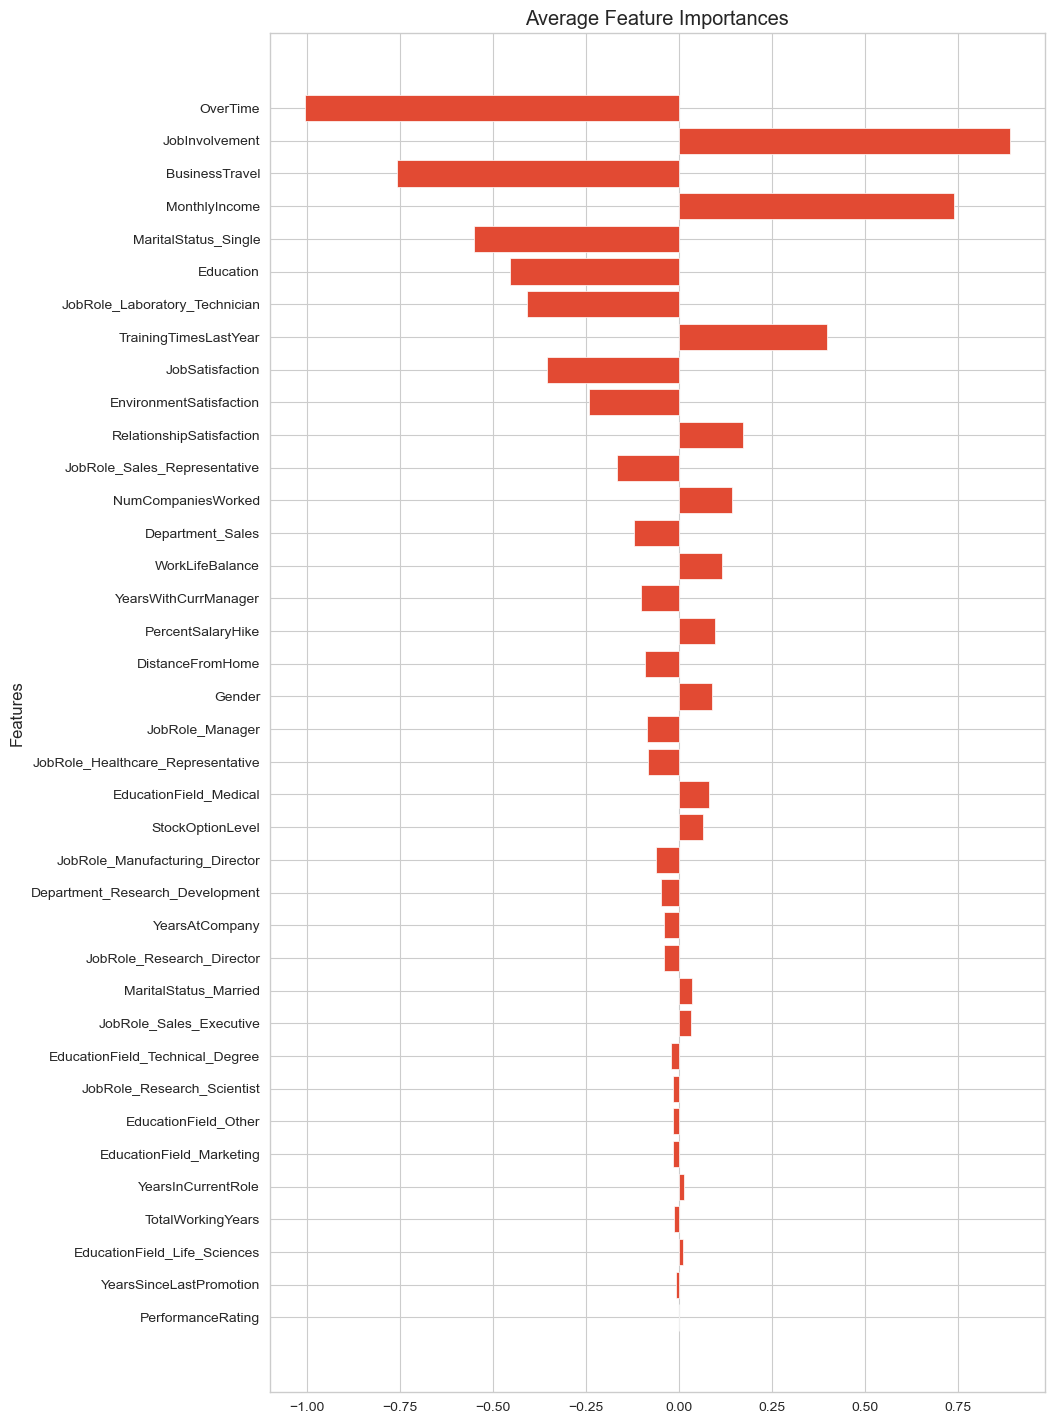

In [48]:
def visualize_importances(feature_names, importances, title="Average Feature Importances", plot=True, axis_title="Features"):
    print(title)
    sorted_indexes = np.argsort(abs(importances))
    for i in sorted_indexes[::-1]:
        print(feature_names[i], ": ", '%.3f'%(importances[i]))
    x_pos = (np.arange(len(feature_names)))

    sorted_importances = [importances[i] for i in sorted_indexes]
    sorted_feature_names = [feature_names[i] for i in sorted_indexes]
    if plot:
        plt.figure(figsize=(10,18))
        plt.barh(x_pos , sorted_importances, align='center')
        plt.yticks(x_pos, sorted_feature_names, wrap=True)
        plt.ylabel(axis_title)
        plt.title(title)

feature_names = list(df_features.columns)
visualize_importances(feature_names, np.mean(attr, axis=0))